# Exploring Ensemble Methods
In this assignment, we will explore the use of boosting. We will use the pre-implemented gradient boosted trees in scikit-learn. You will:

* First to do some feature engineering.
* Train a boosted ensemble of decision-trees (gradient boosted trees), predict whether a loan will default(on a validation set).
* Evaluate the trained model and compare it with a baseline.
* Explore how the number of trees influences classification performance
* Visualize the classification performance with different number of trees

In [52]:
import pandas as pd
import numpy as np
import json
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Load LendingClub dataset

We will be using the [LendingClub](https://www.lendingclub.com/) data. As discussed earlier, the [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. 

Just like we did in previous assignments, we will build a classification model to predict whether or not a loan provided by lending club is likely to default.

Let us start by loading the data.

In [2]:
loans = pd.read_csv('data_files/lending-club-data.csv')
print(loans.shape)

(122607, 68)


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (19,47) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

## Modifying the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

As in past assignments, in order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [5]:
loans['safe_loans']=loans['bad_loans'].apply(lambda x: +1 if x==0 else -1)
loans = loans.drop('bad_loans', axis=1)

## Selecting features

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [7]:
target = 'safe_loans'
features = ['grade',                     # grade of the loan (categorical)
            'sub_grade_num',             # sub-grade of the loan as a number from 0 to 1
            'short_emp',                 # one year or less of employment
            'emp_length_num',            # number of years of employment
            'home_ownership',            # home_ownership status: own, mortgage or rent
            'dti',                       # debt to income ratio
            'purpose',                   # the purpose of the loan
            'payment_inc_ratio',         # ratio of the monthly payment to income
            'delinq_2yrs',               # number of delinquincies 
            'delinq_2yrs_zero',          # no delinquincies in last 2 years
            'inq_last_6mths',            # number of creditor inquiries in last 6 months
            'last_delinq_none',          # has borrower had a delinquincy
            'last_major_derog_none',     # has borrower had 90 day or worse rating
            'open_acc',                  # number of open credit accounts
            'pub_rec',                   # number of derogatory public records
            'pub_rec_zero',              # no derogatory public records
            'revol_util',                # percent of available credit being used
            'total_rec_late_fee',        # total late fees received to day
            'int_rate',                  # interest rate of the loan
            'total_rec_int',             # interest received to date
            'annual_inc',                # annual income of borrower
            'funded_amnt',               # amount committed to the loan
            'funded_amnt_inv',           # amount committed by investors for the loan
            'installment',               # monthly payment owed by the borrower
           ]

## Skipping observations with missing values

Recall from the lectures that one common approach to coping with missing values is to **skip** observations that contain missing values.

We run the following code to do so:

In [8]:
loans = loans[[target]+features].dropna()
print(loans.shape)

(122578, 25)


## Subample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

Purpose: Deal with imbalanced data by subsampling the overly represented class to get a more balanced dataset

In [9]:
#safe_loans_raw = loans[loans[target] == +1]
#risky_loans_raw = loans[loans[target] == -1]
#print("Number of safe loans  : %s" % len(safe_loans_raw))
#print("Number of risky loans : %s" % len(risky_loans_raw))

# Since there are fewer risky loans than safe loans, find the ratio of the sizes
# and use that percentage to undersample the safe loans.
#percentage = len(risky_loans_raw)/float(len(safe_loans_raw))

#risky_loans = risky_loans_raw
#safe_loans = safe_loans_raw.sample(percentage, seed=1)

# Append the risky_loans with the downsampled version of safe_loans
#loans_data = risky_loans.append(safe_loans)

## One-hot Encoding

In [10]:
loans = loans.fillna('n/a')

In [11]:
categorical_variables = []
for feat_name, feat_type in zip(loans.columns, loans.dtypes):
    if feat_type == object:
        categorical_variables.append(feat_name)
        
for feature in categorical_variables:
    
    loans_one_hot_encoded = pd.get_dummies(loans[feature],prefix=feature)
    loans_one_hot_encoded.fillna(0)
    #print loans_one_hot_encoded
    
    loans = loans.drop(feature, axis=1)
    for col in loans_one_hot_encoded.columns:
        loans[col] = loans_one_hot_encoded[col]

In [12]:
loans.columns

Index(['safe_loans', 'sub_grade_num', 'short_emp', 'emp_length_num', 'dti',
       'payment_inc_ratio', 'delinq_2yrs', 'delinq_2yrs_zero',
       'inq_last_6mths', 'last_delinq_none', 'last_major_derog_none',
       'open_acc', 'pub_rec', 'pub_rec_zero', 'revol_util',
       'total_rec_late_fee', 'int_rate', 'total_rec_int', 'annual_inc',
       'funded_amnt', 'funded_amnt_inv', 'installment', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G',
       'home_ownership_MORTGAGE', 'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'purpose_car', 'purpose_credit_card',
       'purpose_debt_consolidation', 'purpose_home_improvement',
       'purpose_house', 'purpose_major_purchase', 'purpose_medical',
       'purpose_moving', 'purpose_other', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding'],
      dtype='object')

## Split data into training and validation sets

In [13]:
with open('data_files/module-8-assignment-1-train-idx.json') as train_data_file:    
    train_idx  = json.load(train_data_file)
with open('data_files/module-8-assignment-1-validation-idx.json') as validation_data_file:    
    validation_idx = json.load(validation_data_file)
    
train_data = loans.iloc[train_idx]
valid_data = loans.iloc[validation_idx]

print(train_data.shape, valid_data.shape)

(37219, 45) (9284, 45)


# Gradient Boosted tree classifier

Gradient boosted trees are a powerful variant of boosting methods; they have been used to win many [Kaggle](https://www.kaggle.com/) competitions, and have been widely used in industry.  We will explore the predictive power of multiple decision trees as opposed to a single decision tree.

We will now train models to predict `safe_loans` using the features above. In this section, we will experiment with training an ensemble of 5 trees. To cap the ensemble classifier at 5 trees, we call the function with **max_iterations=5** (recall that each iterations corresponds to adding a tree). To limit the depth of each tree, set **max_depth=6**.

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
train_Y = train_data['safe_loans']
train_X = train_data.drop('safe_loans', axis=1)
print (train_Y.shape)
print (train_X.shape)

(37219,)
(37219, 44)


In [15]:
model_5 = GradientBoostingClassifier(n_estimators=5, max_depth=6).fit(train_X, train_Y)

# Making predictions

Just like we did in previous sections, let us consider a few positive and negative examples **from the validation set**. We will do the following:
* Predict whether or not a loan is likely to default.
* Predict the probability with which the loan is likely to default.

In [19]:
# Select all positive and negative examples.
valid_safe_loans = valid_data[valid_data[target] == 1]
valid_risky_loans = valid_data[valid_data[target] == -1]

# Select 2 examples from the validation set for positive & negative loans
sample_valid_data_risky = valid_risky_loans[0:2]
sample_valid_data_safe = valid_safe_loans[0:2]

# Append the 4 examples into a single dataset
sample_valid_data = sample_valid_data_safe.append(sample_valid_data_risky)
sample_valid_data

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding
22,1,0.2,0,3,29.44,6.30496,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
26,1,0.6,1,1,12.19,13.49520,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0
24,-1,0.4,0,3,13.97,2.96736,3.0,0.0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
41,-1,1.0,0,11,16.33,1.90524,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0


In [20]:
model_5.predict(sample_valid_data.drop('safe_loans', axis=1))

array([ 1,  1, -1,  1])

In [21]:
model_5.predict_proba(sample_valid_data.drop('safe_loans', axis=1))

array([[0.41642331, 0.58357669],
       [0.46949689, 0.53050311],
       [0.53807792, 0.46192208],
       [0.39591639, 0.60408361]])

## Evaluating the model on the validation data
Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Evaluate the accuracy of the **model_5** on the **validation_data**.

In [22]:
valid_Y = valid_data['safe_loans'].to_numpy()  #to_numpy: convert to numpy array
valid_X = valid_data.drop('safe_loans', axis=1)
print (valid_Y.shape)
print (valid_X.shape)

(9284,)
(9284, 44)


In [24]:
prediction = model_5.predict(valid_X)
print(prediction[:5])
print(valid_Y[:5])
print(type(prediction))
print(type(valid_Y))

[-1  1 -1 -1  1]
[-1 -1 -1 -1 -1]
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [27]:
correct_num = np.sum(prediction==valid_Y)
total_num = len(valid_Y)
accuracy = correct_num / total_num
print('The accuracy of model5 on validation set is', accuracy)

The accuracy of model5 on validation set is 0.6612451529513141


In [33]:
false_positive_num = np.sum((prediction==1)*(valid_Y==-1))
print(false_positive_num)

1654


In [34]:
false_negative_num = np.sum((prediction==-1)*(valid_Y==1))
print(false_negative_num)

1491


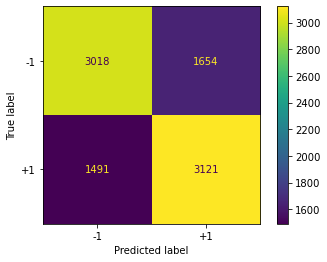

In [35]:
plot_confusion_matrix(model_5, valid_X, valid_Y, display_labels =['-1','+1'])

## Comparison with decision trees

In the earlier assignment, we saw that the prediction accuracy of the decision trees was around **0.64** (rounded). In this assignment, we saw that **model_5** has an accuracy of **0.67** (rounded).

Here, we quantify the benefit of the extra 3% increase in accuracy of **model_5** in comparison with a single decision tree from the original decision tree assignment.

As we explored in the earlier assignment, we calculated the cost of the mistakes made by the model. We again consider the same costs as follows:

* **False negatives**: Assume a cost of \$10,000 per false negative.
* **False positives**: Assume a cost of \$20,000 per false positive.

Assume that the number of false positives and false negatives for the learned decision tree was

* **False negatives**: 1936
* **False positives**: 1503

Using the costs defined above and the number of false positives and false negatives for the decision tree, we can calculate the total cost of the mistakes made by the decision tree model as follows:

```
cost = $10,000 * 1936  + $20,000 * 1503 = $49,420,000
```

The total cost of the mistakes of the model is $49.42M. That is a **lot of money**!.

In [37]:
total_cost = false_negative_num*10000+false_positive_num*20000
print('Total cost is:',total_cost)    

Total cost is: 47990000


## Most positive & negative loans.

In this section, we will find the loans that are most likely to be predicted **safe**. We can do this in a few steps:

* **Step 1**: Use the **model_5** (the model with 5 trees) and make **probability predictions** for all the loans in the **validation_data**.
* **Step 2**: Similar to what we did in the very first assignment, add the probability predictions as a column called **predictions** into the validation_data.
* **Step 3**: Sort the data (in descreasing order) by the probability predictions.

In [38]:
proba_predictions = model_5.predict_proba(valid_X)
proba_predictions

array([[0.53807792, 0.46192208],
       [0.39591639, 0.60408361],
       [0.52012758, 0.47987242],
       ...,
       [0.53530977, 0.46469023],
       [0.52280924, 0.47719076],
       [0.53807792, 0.46192208]])

In [40]:
proba_predictions_positive = proba_predictions[:,1]
proba_predictions_positive

array([0.46192208, 0.60408361, 0.47987242, ..., 0.46469023, 0.47719076,
       0.46192208])

In [42]:
valid_data['proba_predictions'] = proba_predictions_positive

<ipython-input-42-5db09c86caf0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['proba_predictions'] = proba_predictions_positive


In [44]:
valid_data.sort_values('proba_predictions',ascending= False)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,proba_predictions
8021,-1,0.4,0,4,12.73,12.16700,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.673059
92079,1,0.2,0,8,10.02,3.49357,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,1,0.661468
17506,1,0.8,0,9,12.68,0.74424,0.0,1.0,0.0,0,...,0,0,0,0,0,0,0,0,0,0.661468
109930,1,0.4,0,4,13.75,2.03093,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
14481,1,0.2,0,5,8.16,2.46989,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84921,-1,0.8,0,9,8.54,7.48113,0.0,1.0,2.0,0,...,0,0,0,0,0,1,0,0,0,0.315969
101746,-1,0.2,0,11,11.21,4.23624,0.0,1.0,3.0,1,...,0,0,1,0,0,0,0,0,0,0.315969
27502,-1,1.0,0,3,8.53,14.62800,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0.312806
84508,-1,0.8,1,1,7.37,16.62070,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.307334


In [46]:
valid_data.sort_values('proba_predictions',ascending= True)

,safe_loans,sub_grade_num,short_emp,emp_length_num,dti,payment_inc_ratio,delinq_2yrs,delinq_2yrs_zero,inq_last_6mths,last_delinq_none,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,proba_predictions
58794,-1,0.8,0,2,8.66,17.62510,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.307334
84508,-1,0.8,1,1,7.37,16.62070,0.0,1.0,1.0,1,...,0,0,0,0,0,0,0,0,0,0.307334
27502,-1,1.0,0,3,8.53,14.62800,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0.312806
101746,-1,0.2,0,11,11.21,4.23624,0.0,1.0,3.0,1,...,0,0,1,0,0,0,0,0,0,0.315969
114781,-1,0.4,0,3,21.90,7.18760,1.0,0.0,4.0,0,...,0,0,0,0,0,0,0,0,0,0.315969
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109114,1,0.6,0,9,12.53,11.13550,1.0,0.0,1.0,0,...,0,0,0,0,0,0,0,0,0,0.661468
10911,1,0.2,0,4,5.33,2.48820,0.0,1.0,0.0,1,...,0,0,0,0,0,0,0,0,0,0.661468
60808,1,0.2,0,2,0.62,4.56538,0.0,1.0,0.0,1,...,1,0,0,0,0,0,0,0,0,0.661468
26165,1,0.4,0,4,12.76,1.73760,0.0,1.0,2.0,1,...,0,0,0,0,0,0,0,0,0,0.661468


## Effect of adding more trees

In this assignment, we will train 5 different ensemble classifiers in the form of gradient boosted trees. We will train models with 10, 50, 100, 200, and 500 trees.  We use the **max_iterations** parameter in the boosted tree module. 

Let's get sarted with a model with **max_iterations = 10**

Now, train 4 models with **max_iterations** to be:
* `max_iterations = 50`, 
* `max_iterations = 100`
* `max_iterations = 200`
* `max_iterations = 500`. 

Let us call these models **model_50**, **model_100**, **model_200**, and **model_500**. You can pass in `verbose=False` in order to suppress the printed output.

**Warning:** This could take a couple of minutes to run.

In [47]:
model_10 = GradientBoostingClassifier(n_estimators=10, max_depth=6).fit(train_X, train_Y)
model_50 = GradientBoostingClassifier(n_estimators=50, max_depth=6).fit(train_X, train_Y)
model_100 = GradientBoostingClassifier(n_estimators=100, max_depth=6).fit(train_X, train_Y)
model_200 = GradientBoostingClassifier(n_estimators=200, max_depth=6).fit(train_X, train_Y)
model_500 = GradientBoostingClassifier(n_estimators=500, max_depth=6).fit(train_X, train_Y)

In [48]:
print (model_10.score(valid_X,valid_Y))   # accuracy on validation set
print (model_50.score(valid_X,valid_Y))
print (model_100.score(valid_X,valid_Y))
print (model_200.score(valid_X,valid_Y))
print (model_500.score(valid_X,valid_Y))

0.6661999138302456
0.684510986643688
0.6906505816458423
0.6900043084877208
0.6876346402412753


In [49]:
train_error_10 = 1 - model_10.score(train_X,train_Y)  # errors on training set
train_error_50 = 1 - model_50.score(train_X,train_Y)
train_error_100 = 1 - model_100.score(train_X,train_Y)
train_error_200 = 1 - model_200.score(train_X,train_Y)
train_error_500 = 1 - model_500.score(train_X,train_Y)

In [51]:
valid_error_10 = 1 - model_10.score(valid_X,valid_Y)  # errors on validation set
valid_error_50 = 1 - model_50.score(valid_X,valid_Y)
valid_error_100 = 1 - model_100.score(valid_X,valid_Y)
valid_error_200 = 1 - model_200.score(valid_X,valid_Y)
valid_error_500 = 1 - model_500.score(valid_X,valid_Y)

In [53]:
training_errors = [train_error_10, train_error_50, train_error_100, 
                   train_error_200, train_error_500]

In [56]:
validation_errors = [valid_error_10, valid_error_50, valid_error_100, 
                     valid_error_200, valid_error_500]

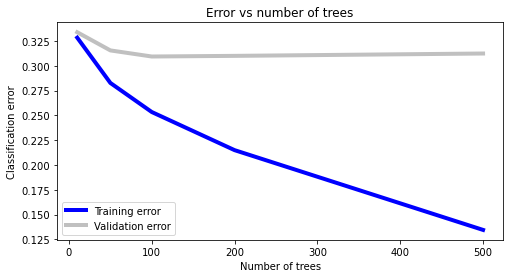

In [59]:
fig,ax = plt.subplots(figsize=(8,4))

ax.plot([10, 50, 100, 200, 500], training_errors, linewidth=4.0, 
         label='Training error', color = 'blue')
ax.plot([10, 50, 100, 200, 500], validation_errors, linewidth=4.0, 
         label='Validation error', color = 'silver')

ax.set_xlabel('Number of trees')
ax.set_ylabel('Classification error')
ax.set_title('Error vs number of trees')
ax.legend()

plt.show()